In [167]:
import pickle

with open('dataframes.pkl', 'rb') as file:
    data = pickle.load(file)

yk_full = data['yk_full']
yk_dropped = data['yk_dropped']

In [168]:
yk_full.shape

(1025, 21)

In [169]:
yk_dropped.shape

(902, 21)

In [170]:
import pandas as pd 

yk_dropped['Distribution Type'].value_counts()

longtail      264
normal        255
outlier       239
bimodal        78
functional     37
discrete       29
Name: Distribution Type, dtype: int64

In [171]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

columns_to_drop = ['Target', 'Name', 'Distribution Type']
X = yk_dropped.drop(columns = columns_to_drop)
y = yk_dropped['Distribution Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model to detect outlier only

In [172]:
# converting target label to classify outliers only 
y_train_outlier = y_train.apply(lambda x: 1 if x == 'outlier' else 0)
y_test_outlier = y_test.apply(lambda x: 1 if x == 'outlier' else 0)

In [173]:
model_outlier = RandomForestClassifier()

model_outlier.fit(X_train, y_train_outlier)

y_pred_outlier = model_outlier.predict(X_test)
y_proba_outlier = model_outlier.predict_proba(X_test)

In [174]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test_outlier, y_pred_outlier))
print("Classification Report:\n", classification_report(y_test_outlier, y_pred_outlier))

Accuracy: 0.9558011049723757
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       136
           1       0.95      0.87      0.91        45

    accuracy                           0.96       181
   macro avg       0.95      0.93      0.94       181
weighted avg       0.96      0.96      0.96       181



# Trail model to detect longtail only 

In [175]:
# converting target label to classify longtail only 
y_train_longtail = y_train.apply(lambda x: 1 if x == 'longtail' else 0)
y_test_longtail = y_test.apply(lambda x: 1 if x == 'longtail' else 0)

In [176]:
model_longtail = RandomForestClassifier()

model_longtail.fit(X_train, y_train_longtail)

y_pred_longtail = model_longtail.predict(X_test)
y_proba_longtail = model_longtail.predict_proba(X_test)

In [177]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test_longtail, y_pred_longtail))
print("Classification Report:\n", classification_report(y_test_longtail, y_pred_longtail))

Accuracy: 0.8784530386740331
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.91       121
           1       0.88      0.73      0.80        60

    accuracy                           0.88       181
   macro avg       0.88      0.84      0.86       181
weighted avg       0.88      0.88      0.88       181



In [178]:
final_predictions = []

outlier_preds = []
longtail_preds = []
either_preds = []

outlier = model_outlier.predict(X_test)
longtail = model_longtail.predict(X_test)

for i in range(len(outlier)):
    outlier_pred = outlier[i]
    outlier_preds.append(outlier_pred)

    longtail_pred = longtail[i]
    longtail_preds.append(longtail_pred)

    if outlier_pred + longtail_pred >= 1:
        either_preds.append(1)
    else:
        either_preds.append(0)
    
predictions = pd.DataFrame({
    'Outlier': outlier_preds,
    'Longtail': longtail_preds,
    'Either': either_preds
})

In [179]:
predictions

,Outlier,Longtail,Either
0,0,1,1
1,1,0,1
2,0,0,0
3,1,0,1
4,0,0,0
...,...,...,...
176,1,0,1
177,0,0,0
178,1,0,1
179,0,0,0


In [192]:
# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score

y_test_either = y_test.apply(lambda x: 1 if x in ['outlier', 'longtail'] else 0)
y_pred_either = predictions['Either']

print("Accuracy:", accuracy_score(y_test_either, y_pred_either))
print("Classification Report:\n", classification_report(y_test_either, y_pred_either))

Accuracy: 0.8784530386740331
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.95      0.87        76
           1       0.96      0.83      0.89       105

    accuracy                           0.88       181
   macro avg       0.88      0.89      0.88       181
weighted avg       0.89      0.88      0.88       181



In [193]:
y_train_encoded = y_train.apply(lambda x: 1 if x in ['outlier', 'longtail'] else 0)
y_test_encoded = y_test.apply(lambda x: 1 if x in ['outlier', 'longtail'] else 0)

In [194]:
from catboost import CatBoostClassifier

# Create and train the CatBoost model
catboost_model = CatBoostClassifier(random_state=42, verbose=0)
catboost_model.fit(X_train, y_train_encoded)

catboost_preds = catboost_model.predict(X_test)

In [195]:
print("Accuracy:", accuracy_score(y_test_encoded, catboost_preds))
print("Classification Report:\n", classification_report(y_test_encoded, catboost_preds))

Accuracy: 0.8950276243093923
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.96      0.88        76
           1       0.97      0.85      0.90       105

    accuracy                           0.90       181
   macro avg       0.89      0.90      0.89       181
weighted avg       0.91      0.90      0.90       181



# Analysis of unrecalled points

In [198]:
unrecalled_mask = (y_test_encoded == 1) & (catboost_preds != 1)
unrecalled_points = X_test[unrecalled_mask]


In [201]:
unrecalled_points.describe()

,Mean,Median,Std_Dev,IQR,Skewness,Kurtosis,Min,Max,Range,Percentile_Ratio_95_5,Tail_Weight_Ratio,Excess_Kurtosis,P99,P1,Outliers_Zscore,Outliers_IQR,KS_Stat_norm,KS_P_value_norm
count,1.600000e+01,16.000000,1.600000e+01,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.0,16.000000,1.600000e+01
mean,1.710575e-13,0.022962,1.000008e+00,1.353830,-0.225486,1.142010,-4.883057,4.054635,8.937693,-0.973930,0.047088,-1.857990,2.227552,-2.414234,484.312500,0.0,0.066576,3.773656e-02
std,1.436534e-12,0.098796,1.923827e-07,0.288093,0.795421,3.518495,2.952552,1.456457,2.989743,0.136454,0.040188,3.518495,0.504203,0.625014,694.165179,0.0,0.053484,1.509463e-01
min,-1.326117e-12,-0.219876,1.000007e+00,0.834478,-2.887458,-1.507160,-14.579394,1.550701,3.492165,-1.212412,0.000000,-4.507160,1.406211,-4.290436,0.000000,0.0,0.002981,0.000000e+00
25%,-7.967941e-14,-0.014822,1.000007e+00,1.137652,-0.385997,-0.407527,-5.821375,2.783914,7.929629,-1.079904,0.023018,-3.407527,1.971107,-2.520977,13.000000,0.0,0.035413,9.985418e-294
50%,-2.241640e-15,0.035456,1.000008e+00,1.384448,-0.081553,0.157656,-4.362291,3.807057,8.971182,-0.962851,0.035727,-2.842344,2.110838,-2.271378,233.000000,0.0,0.056692,3.952026e-173
75%,1.428175e-14,0.073597,1.000008e+00,1.481340,0.031580,0.957379,-3.185011,5.127057,9.573425,-0.885462,0.064356,-2.042621,2.386001,-1.987093,551.250000,0.0,0.072773,2.223381e-60
max,5.361646e-12,0.159309,1.000008e+00,1.910543,0.988781,13.462397,-1.941464,6.301798,16.858629,-0.752358,0.128932,10.462397,3.389142,-1.731514,2501.000000,0.0,0.229187,6.037850e-01


In [205]:
recalled_mask = (y_test_encoded == 1) & (catboost_preds == 1)
recalled_points = X_test[recalled_mask]

In [206]:
recalled_points.describe()

,Mean,Median,Std_Dev,IQR,Skewness,Kurtosis,Min,Max,Range,Percentile_Ratio_95_5,Tail_Weight_Ratio,Excess_Kurtosis,P99,P1,Outliers_Zscore,Outliers_IQR,KS_Stat_norm,KS_P_value_norm
count,8.900000e+01,89.000000,8.900000e+01,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,8.900000e+01
mean,2.360656e-12,-0.033279,1.000008e+00,1.181961,-3.994594,1978.943145,-27.989869,16.949564,44.939433,-1.071614,0.053360,1975.943145,2.026423,-1.910499,250.370787,7638.561798,0.103228,1.054616e-02
std,2.249331e-11,0.156675,1.824372e-07,0.440506,37.617392,4839.942562,41.380698,32.969792,49.268053,0.384500,0.053285,4839.942562,0.776670,0.776981,374.769941,21599.556334,0.128729,5.594938e-02
min,-1.544790e-12,-0.745631,1.000007e+00,0.000000,-148.104693,-1.116205,-179.777309,0.006752,4.611648,-2.760089,0.000046,-4.116205,0.002431,-4.022275,0.000000,0.000000,0.003412,0.000000e+00
25%,-8.163854e-14,-0.062742,1.000007e+00,1.034062,-2.154982,0.210932,-32.663810,3.590648,11.171849,-1.188007,0.038145,-2.789068,1.745861,-2.297042,48.000000,0.000000,0.022935,0.000000e+00
50%,1.532158e-17,-0.005238,1.000008e+00,1.285690,0.056626,11.838599,-6.857856,4.429503,24.205318,-1.046887,0.046922,8.838599,2.271826,-2.173364,157.000000,0.000000,0.047006,4.869752e-134
75%,1.818261e-13,0.009570,1.000008e+00,1.340593,0.459980,166.952819,-4.712136,8.117361,58.333882,-0.996877,0.054168,163.952819,2.421352,-1.605864,219.000000,0.000000,0.111366,4.840188e-32
max,2.121369e-10,0.434743,1.000008e+00,1.961446,149.840652,22646.072986,-0.034943,157.577390,205.275915,1.000000,0.399351,22643.072986,5.088797,0.006752,2051.000000,69567.000000,0.502648,4.289933e-01


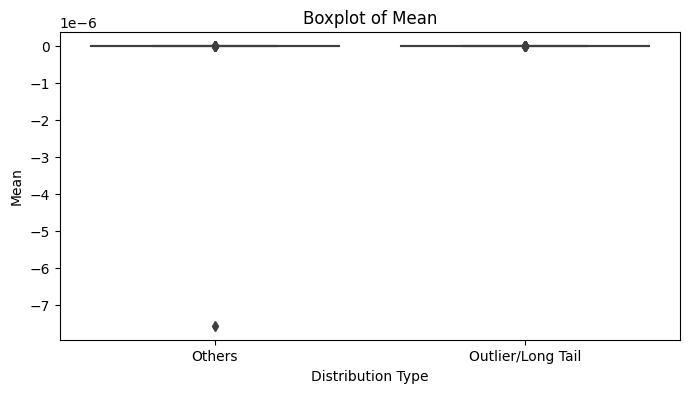

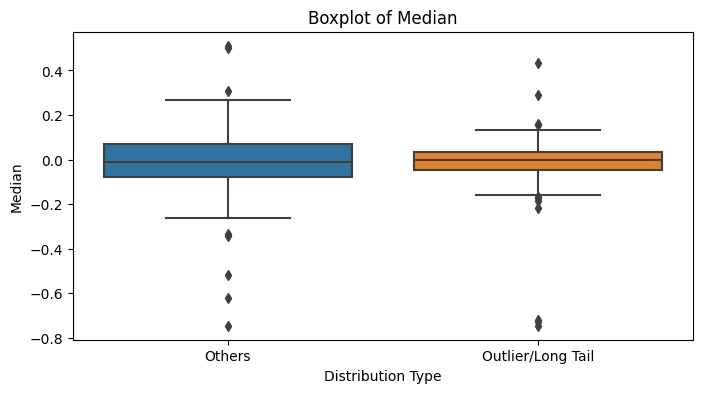

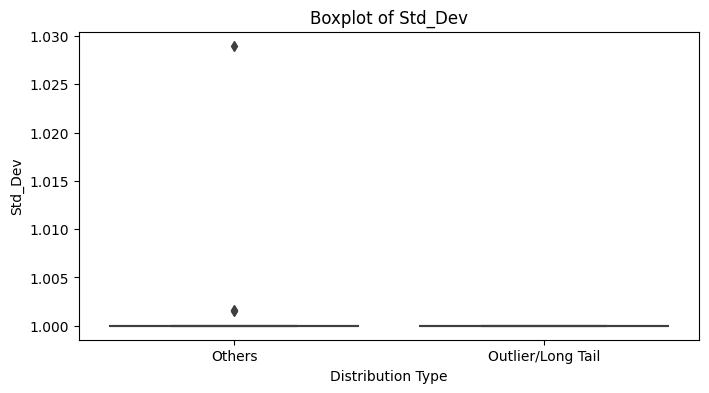

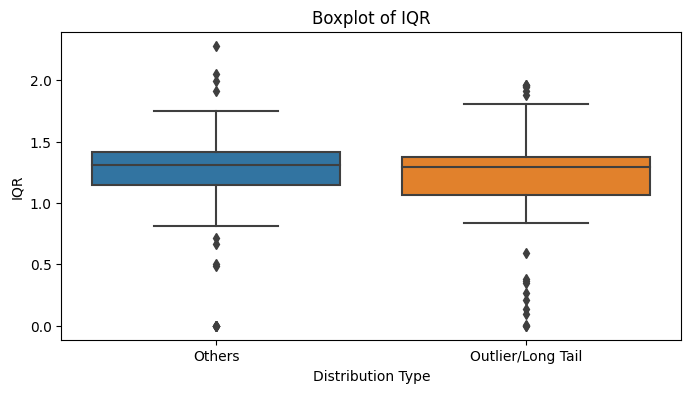

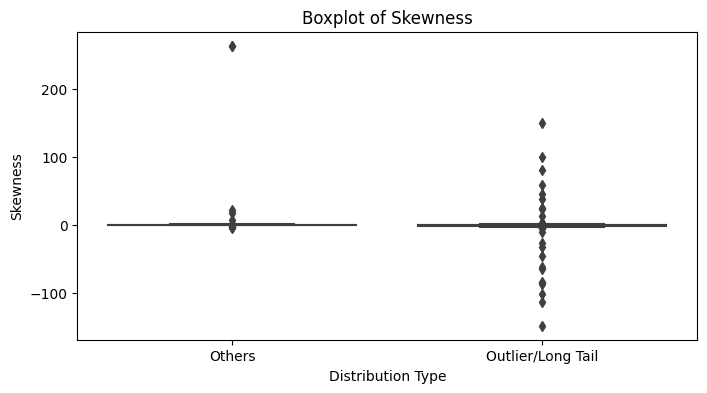

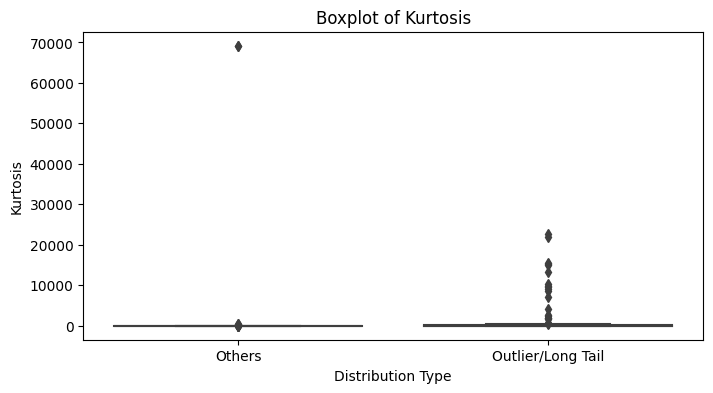

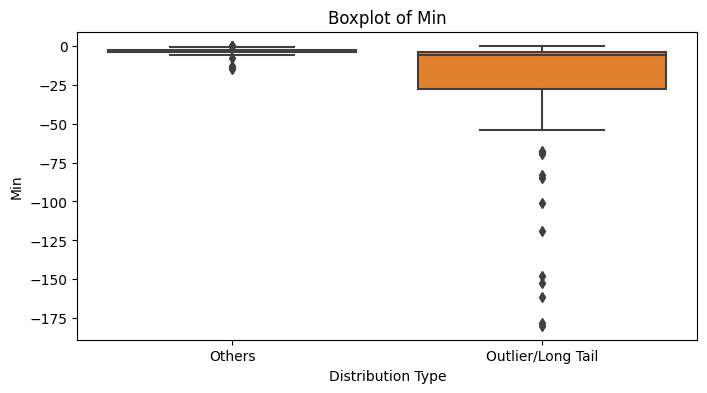

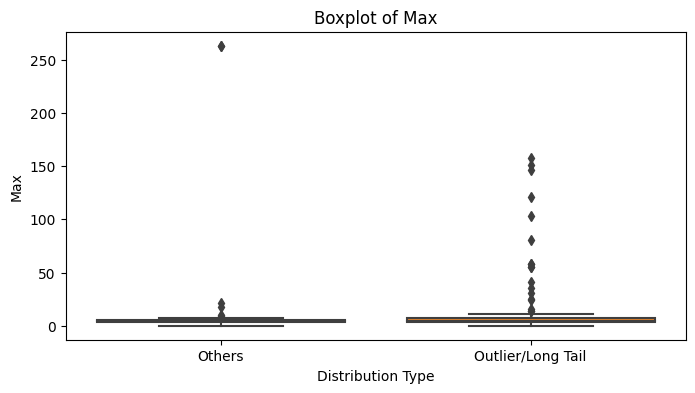

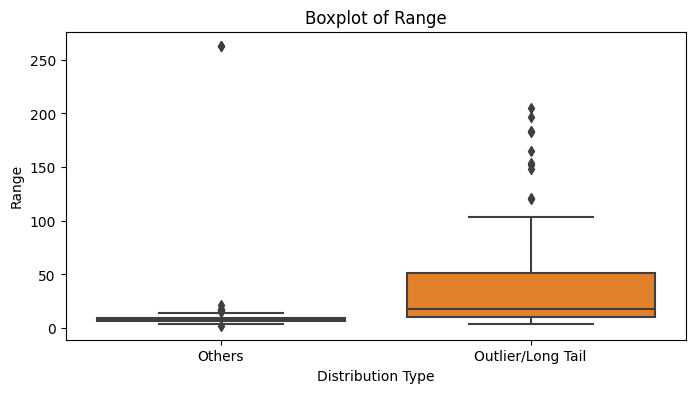

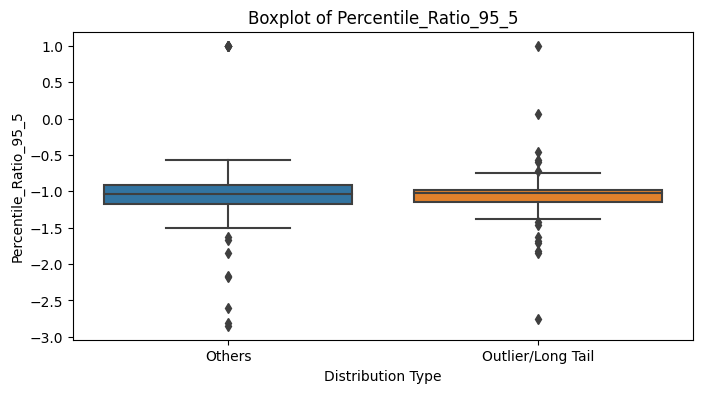

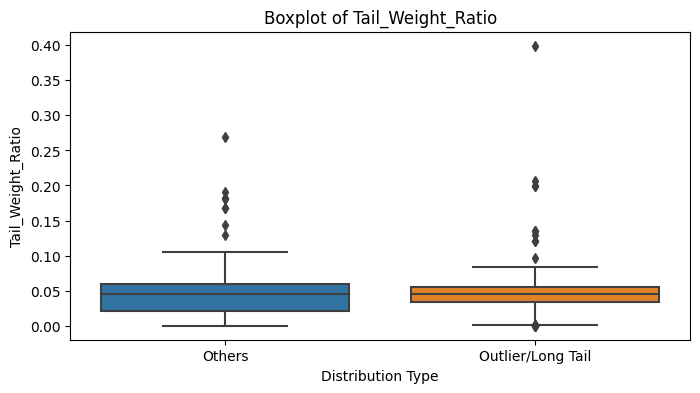

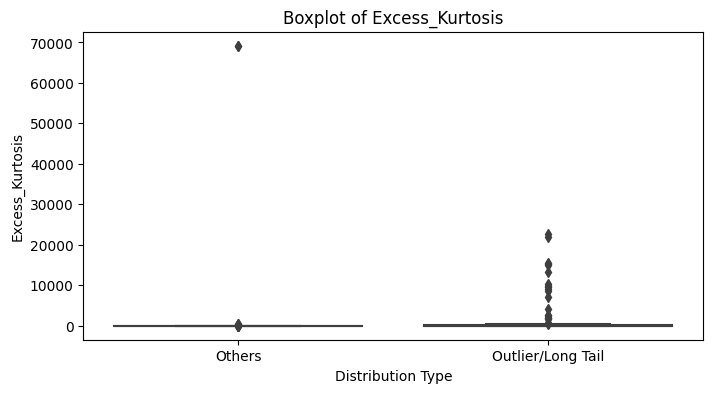

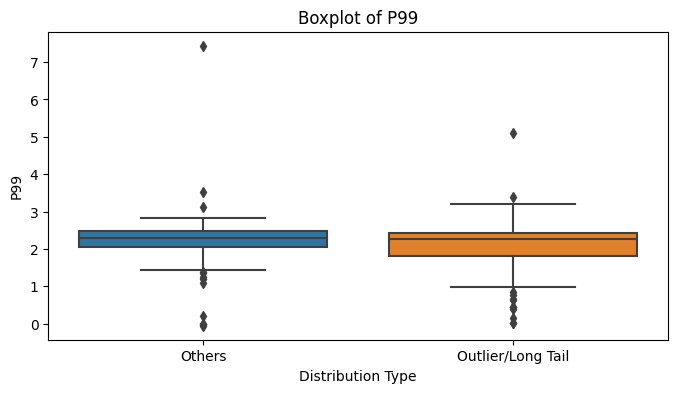

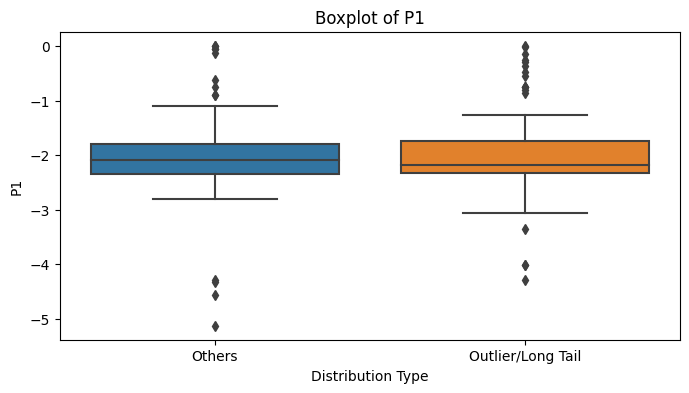

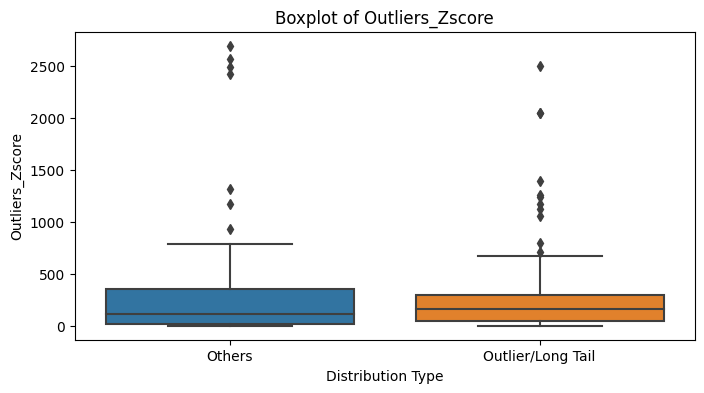

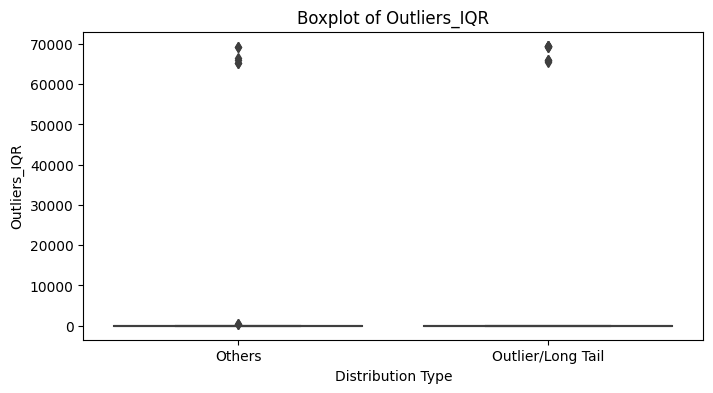

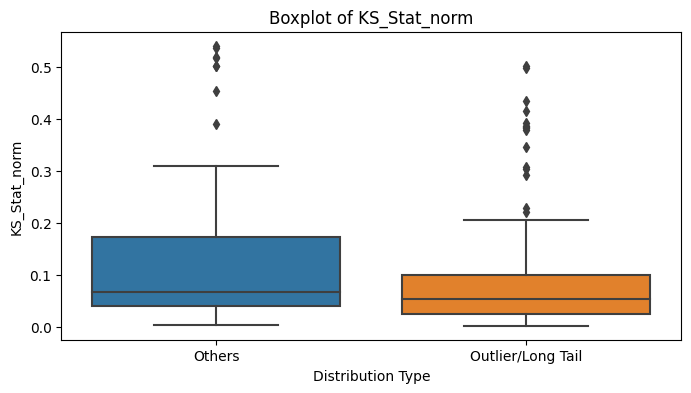

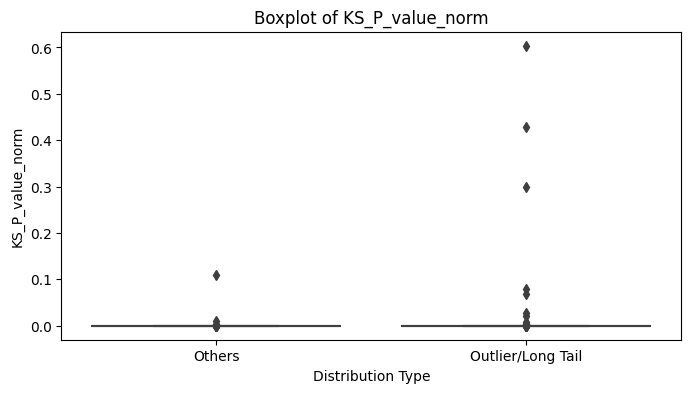

In [218]:
import matplotlib.pyplot as plt
import seaborn as sns

for feature in X_test.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=y_test_encoded, y=feature, data=X_test)
    plt.xticks(ticks=[0, 1], labels=["Others", "Outlier/Long Tail"])
    plt.title(f'Boxplot of {feature}')
    plt.show()

/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recalled_points[feature], label='Correctly Classified (Class 1)', shade=True)
/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(unrecalled_points[feature], label='Unrecalled (Class 1)', shade=True)


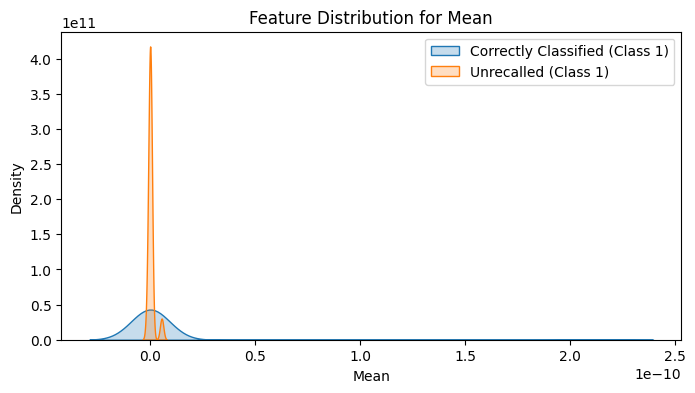

/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recalled_points[feature], label='Correctly Classified (Class 1)', shade=True)
/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(unrecalled_points[feature], label='Unrecalled (Class 1)', shade=True)


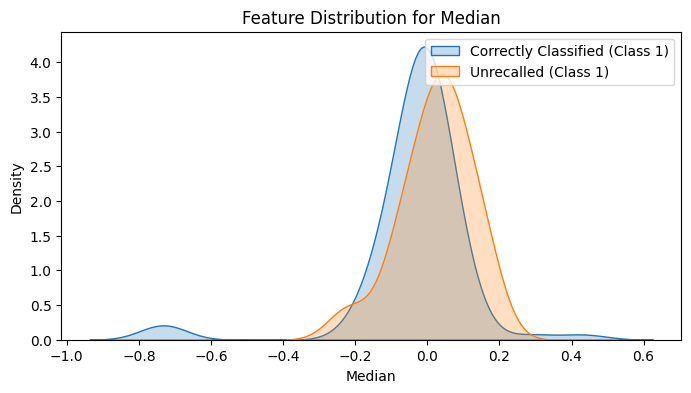

/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recalled_points[feature], label='Correctly Classified (Class 1)', shade=True)
/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(unrecalled_points[feature], label='Unrecalled (Class 1)', shade=True)


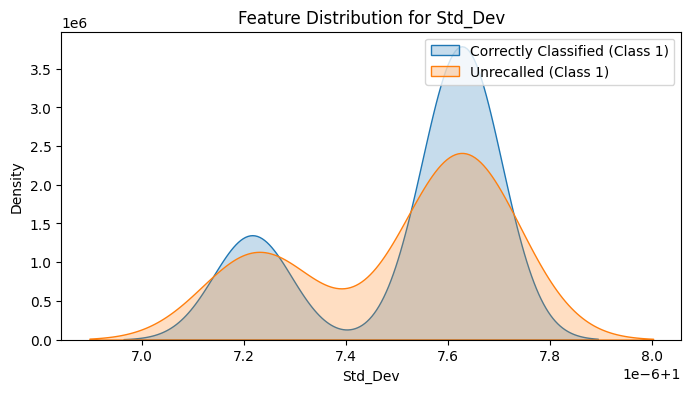

/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recalled_points[feature], label='Correctly Classified (Class 1)', shade=True)
/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(unrecalled_points[feature], label='Unrecalled (Class 1)', shade=True)


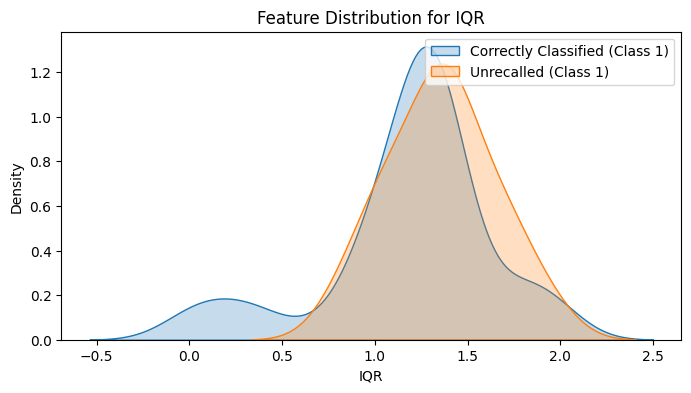

/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recalled_points[feature], label='Correctly Classified (Class 1)', shade=True)
/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(unrecalled_points[feature], label='Unrecalled (Class 1)', shade=True)


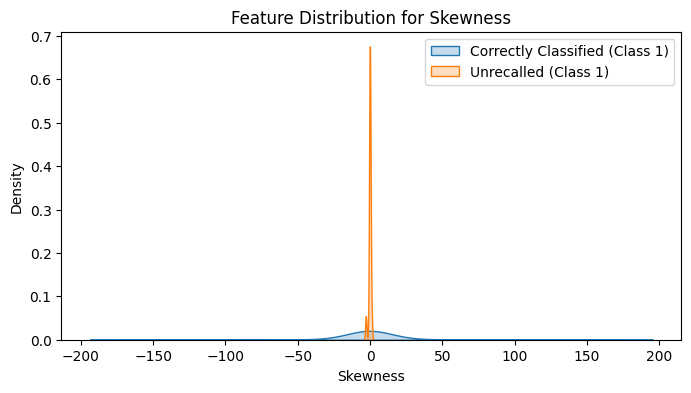

/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recalled_points[feature], label='Correctly Classified (Class 1)', shade=True)
/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(unrecalled_points[feature], label='Unrecalled (Class 1)', shade=True)


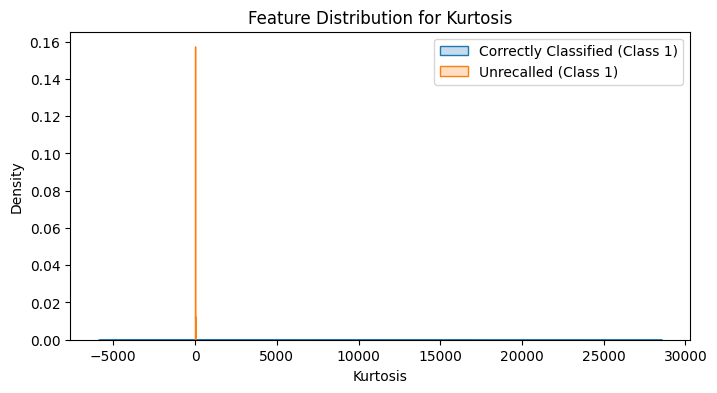

/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recalled_points[feature], label='Correctly Classified (Class 1)', shade=True)
/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(unrecalled_points[feature], label='Unrecalled (Class 1)', shade=True)


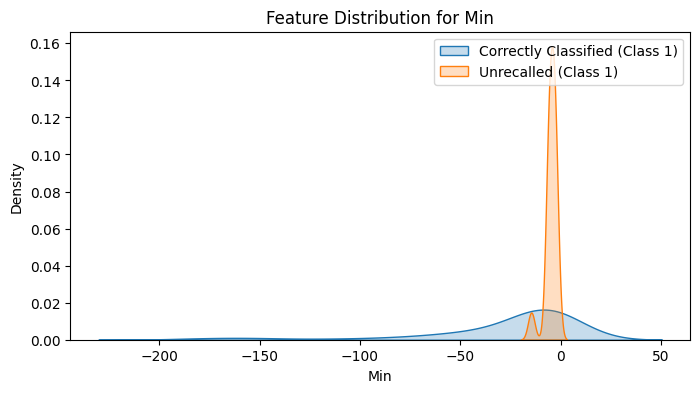

/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recalled_points[feature], label='Correctly Classified (Class 1)', shade=True)
/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(unrecalled_points[feature], label='Unrecalled (Class 1)', shade=True)


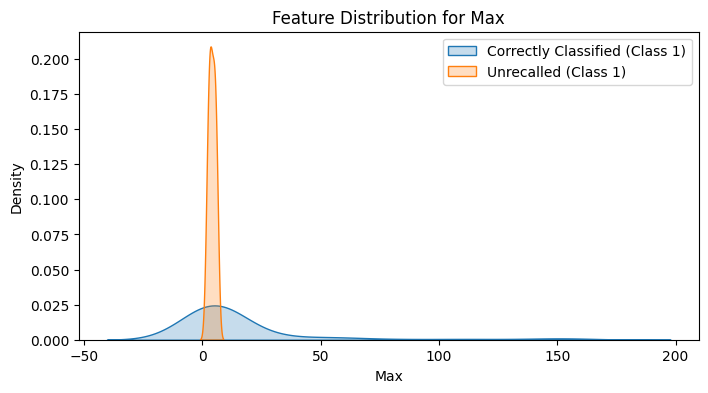

/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recalled_points[feature], label='Correctly Classified (Class 1)', shade=True)
/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(unrecalled_points[feature], label='Unrecalled (Class 1)', shade=True)


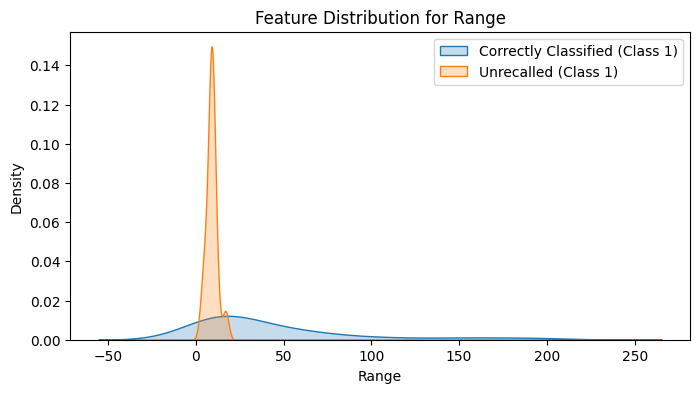

/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recalled_points[feature], label='Correctly Classified (Class 1)', shade=True)
/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(unrecalled_points[feature], label='Unrecalled (Class 1)', shade=True)


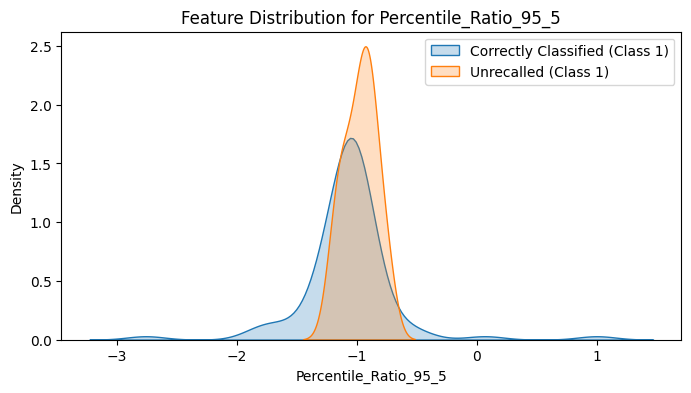

/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recalled_points[feature], label='Correctly Classified (Class 1)', shade=True)
/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(unrecalled_points[feature], label='Unrecalled (Class 1)', shade=True)


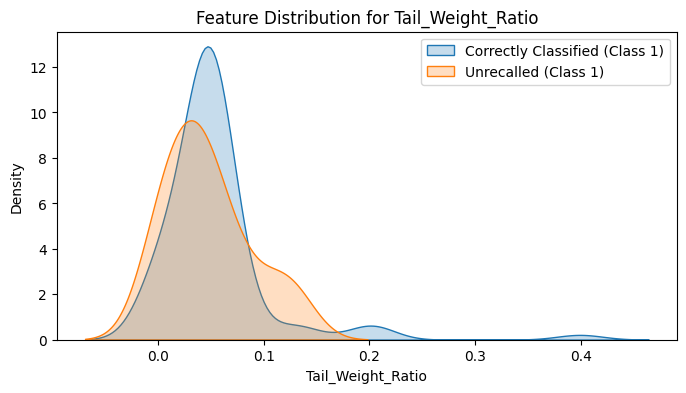

/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recalled_points[feature], label='Correctly Classified (Class 1)', shade=True)
/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(unrecalled_points[feature], label='Unrecalled (Class 1)', shade=True)


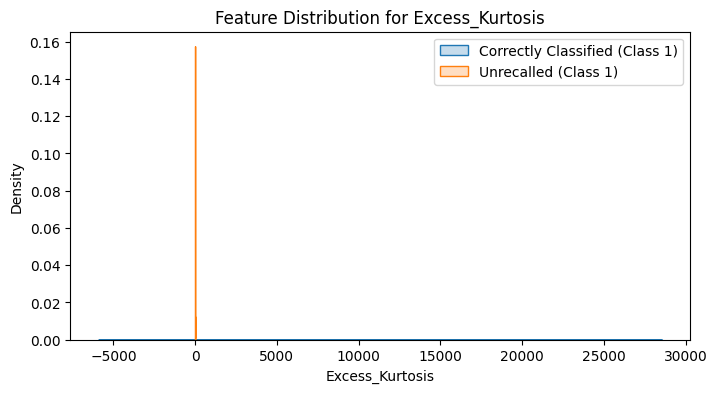

/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recalled_points[feature], label='Correctly Classified (Class 1)', shade=True)
/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(unrecalled_points[feature], label='Unrecalled (Class 1)', shade=True)


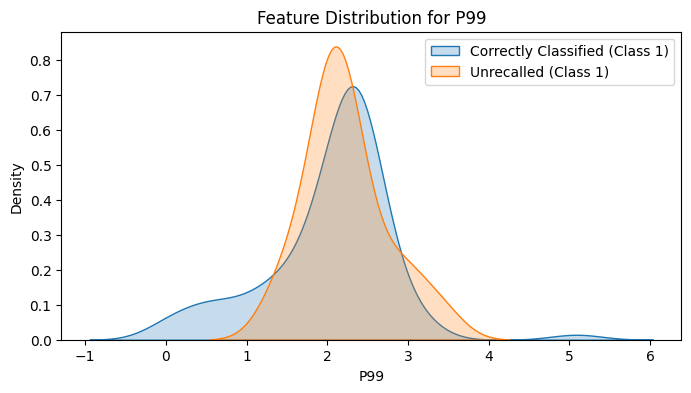

/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recalled_points[feature], label='Correctly Classified (Class 1)', shade=True)
/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(unrecalled_points[feature], label='Unrecalled (Class 1)', shade=True)


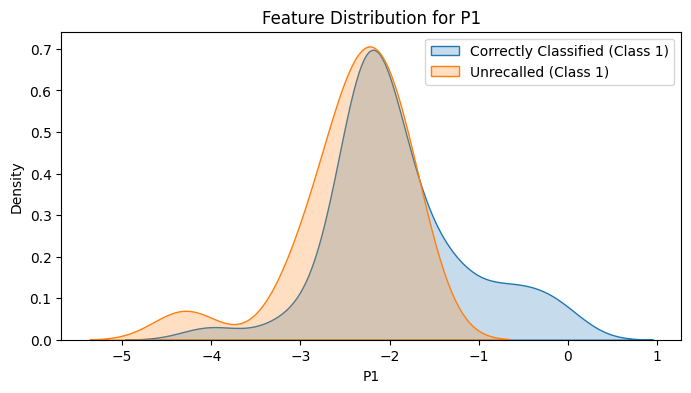

/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recalled_points[feature], label='Correctly Classified (Class 1)', shade=True)
/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(unrecalled_points[feature], label='Unrecalled (Class 1)', shade=True)


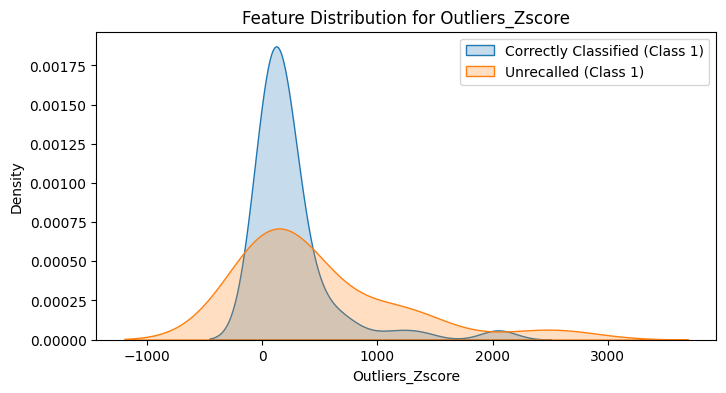

/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recalled_points[feature], label='Correctly Classified (Class 1)', shade=True)
/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(unrecalled_points[feature], label='Unrecalled (Class 1)', shade=True)
/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(unrecalled_points[feature], label='Unrecalled (Class 1)', shade=True)


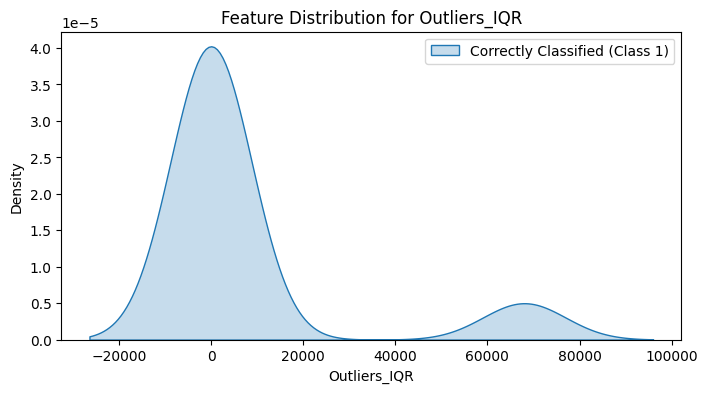

/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recalled_points[feature], label='Correctly Classified (Class 1)', shade=True)
/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(unrecalled_points[feature], label='Unrecalled (Class 1)', shade=True)


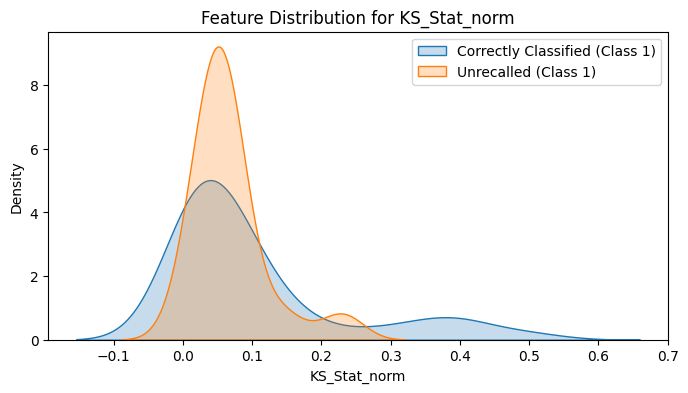

/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(recalled_points[feature], label='Correctly Classified (Class 1)', shade=True)
/var/folders/yp/_xstfn5s2nb1lmynh4_4ghmc0000gn/T/ipykernel_13801/972384953.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(unrecalled_points[feature], label='Unrecalled (Class 1)', shade=True)


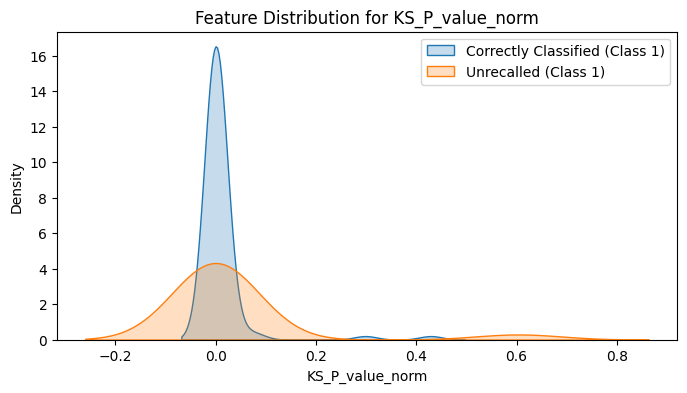

In [207]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance from the model (if applicable)
feature_importance = catboost_model.feature_importances_

# Compare the feature distribution between correctly classified and unrecalled points
for feature in X_test.columns:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(recalled_points[feature], label='Correctly Classified (Class 1)', shade=True)
    sns.kdeplot(unrecalled_points[feature], label='Unrecalled (Class 1)', shade=True)
    plt.title(f'Feature Distribution for {feature}')
    plt.legend()
    plt.show()
